In [204]:
import os
import pickle
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

from lightgbm import LGBMClassifier

In [176]:
sns.set_theme(style="whitegrid")

In [177]:
try:
    BASEDIR = os.path.abspath(os.path.dirname(__file__))
except NameError:
    BASEDIR = os.getcwd()

DBPATH = os.path.join(BASEDIR, "db.sqlite3")

#### Carregamento dos dados

In [178]:
engine = create_engine("sqlite:///" + DBPATH)

In [179]:
with engine.connect() as conn:
    df = pd.read_sql_table("dados", con=conn)

#### Detalhe dos dados

In [180]:
df.head()

,id,nota_exame_ingles,qi,nota_exame_psicotecnico,admitido
0,1,5.41,115,54,0
1,2,7.36,105,77,1
2,3,7.76,96,62,1
3,4,5.51,112,51,0
4,5,7.19,97,47,1


In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       300 non-null    int64  
 1   nota_exame_ingles        300 non-null    float64
 2   qi                       300 non-null    int64  
 3   nota_exame_psicotecnico  300 non-null    int64  
 4   admitido                 300 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 11.8 KB


In [182]:
df.shape

(300, 5)

In [183]:
df.isna().sum()

id                         0
nota_exame_ingles          0
qi                         0
nota_exame_psicotecnico    0
admitido                   0
dtype: int64

In [184]:
df.drop("id", axis=1, inplace=True)

#### Exploratória

In [185]:
df["admitido"].value_counts()

admitido
1    152
0    148
Name: count, dtype: int64

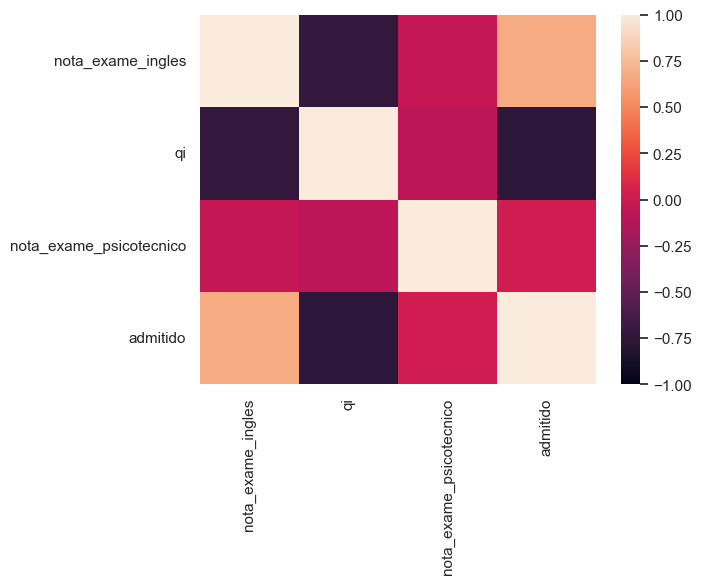

In [186]:
sns.heatmap(df.corr(), vmin=-1, vmax=1)
plt.show()

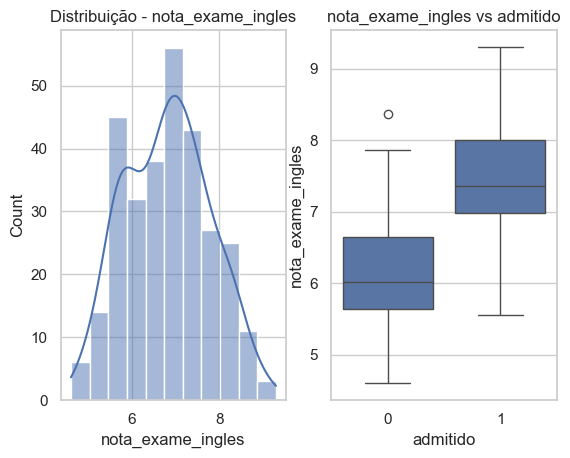

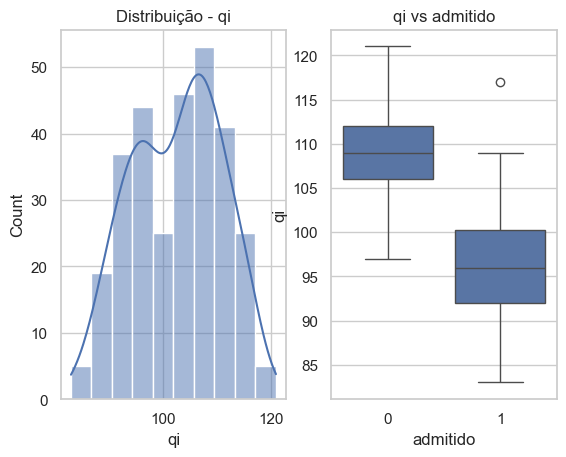

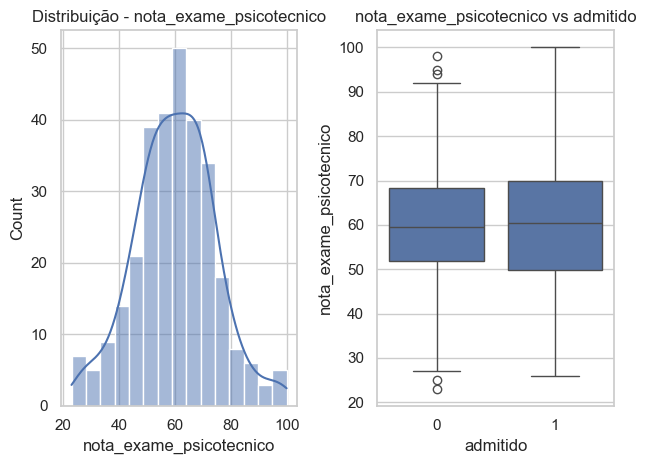

In [187]:
for col in df.columns.drop("admitido"):
    fig, axes = plt.subplots(1, 2)
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(df, x="admitido", y=col, ax=axes[1])
    axes[0].set_title(f"Distribuição - {col}")
    axes[1].set_title(f"{col} vs admitido")

plt.tight_layout()
plt.show()

#### Pré-processamento

In [188]:
X = df.drop("admitido", axis=1)
y = df["admitido"]

In [189]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2
)

In [190]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
# salvando o scaler

pickle.dump(scaler, open(os.path.join(
    BASEDIR, "artifacts", "scaler.pkl"), "wb"))

### Modelos

##### Regressão logistica

In [192]:
model_lg = LogisticRegression()

In [193]:
model_lg.fit(X_train_scaled, y_train)
predicted = model_lg.predict(X_test_scaled)

print("accuracy: ", accuracy_score(y_test, predicted) * 100)
print("classification report: \n", classification_report(y_test, predicted))

accuracy:  90.0
classification report: 
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.88      0.93      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [194]:
model_lg.predict_proba(X_test_scaled)[:10]

array([[0.01973574, 0.98026426],
       [0.99148419, 0.00851581],
       [0.0027106 , 0.9972894 ],
       [0.07927104, 0.92072896],
       [0.01104302, 0.98895698],
       [0.08779373, 0.91220627],
       [0.71587282, 0.28412718],
       [0.01883528, 0.98116472],
       [0.00510786, 0.99489214],
       [0.9051267 , 0.0948733 ]])

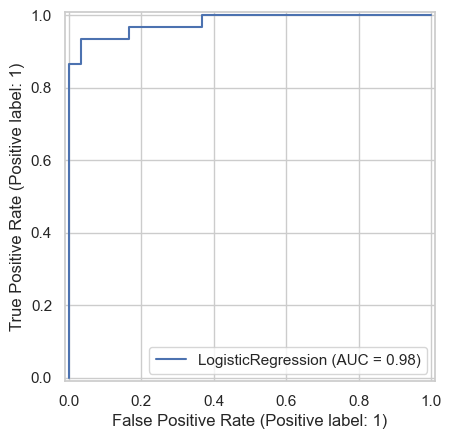

In [195]:
RocCurveDisplay.from_estimator(model_lg, X_test_scaled, y_test)

##### Random Forest

In [196]:
model_rf = RandomForestClassifier(random_state=2)

model_rf.fit(X_train_scaled, y_train)
predicted = model_rf.predict(X_test_scaled)


print("accuracy: ", accuracy_score(y_test, predicted) * 100)
print("classification report: \n", classification_report(y_test, predicted))

accuracy:  90.0
classification report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



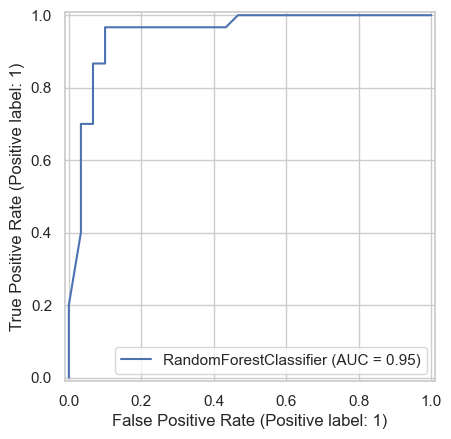

In [197]:
RocCurveDisplay.from_estimator(model_rf, X_test_scaled, y_test)

In [198]:
params = {
    "n_estimators": [100, 120, 130],
    "max_depth": [None, 1, 2, 3],
    "bootstrap": [True, False],
}
grid = GridSearchCV(model_rf, params)
grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=2),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 1, 2, 3],
                         'n_estimators': [100, 120, 130]})

In [199]:
grid.best_estimator_

RandomForestClassifier(max_depth=3, n_estimators=130, random_state=2)

In [200]:
model_rf_1 = RandomForestClassifier(max_depth=2, n_estimators=130, random_state=2)

model_rf_1.fit(X_train_scaled, y_train)
predicted = model_rf_1.predict(X_test_scaled)


print("accuracy: ", accuracy_score(y_test, predicted) * 100)
print("classification report: \n", classification_report(y_test, predicted))

accuracy:  91.66666666666666
classification report: 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.90      0.93      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



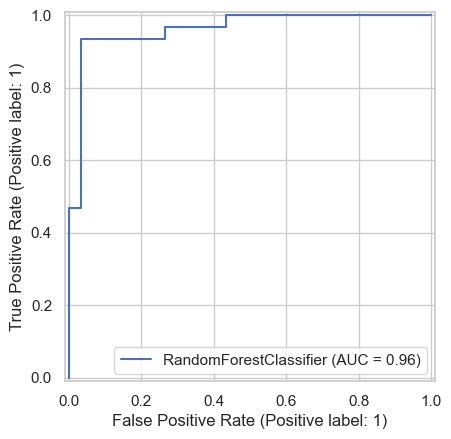

In [201]:
RocCurveDisplay.from_estimator(model_rf_1, X_test_scaled, y_test)

##### Modelo SVM(Classifier)

In [202]:
model_svm = SVC(random_state=2)

model_svm.fit(X_train_scaled, y_train)
predicted = model_svm.predict(X_test_scaled)


print("accuracy: ", accuracy_score(y_test, predicted) * 100)
print("classification report: \n", classification_report(y_test, predicted))

accuracy:  91.66666666666666
classification report: 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.90      0.93      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



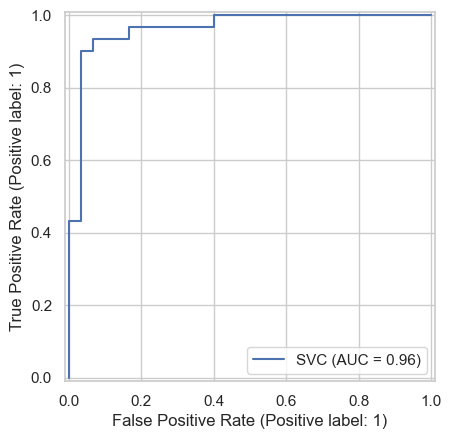

In [203]:
RocCurveDisplay.from_estimator(model_svm, X_test_scaled, y_test)

##### LGBM

In [205]:
model_lgbm = LGBMClassifier(random_state=2)

model_lgbm.fit(X_train_scaled, y_train)
predicted = model_lgbm.predict(X_test_scaled)


print("accuracy: ", accuracy_score(y_test, predicted) * 100)
print("classification report: \n", classification_report(y_test, predicted))

accuracy:  86.66666666666667
classification report: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



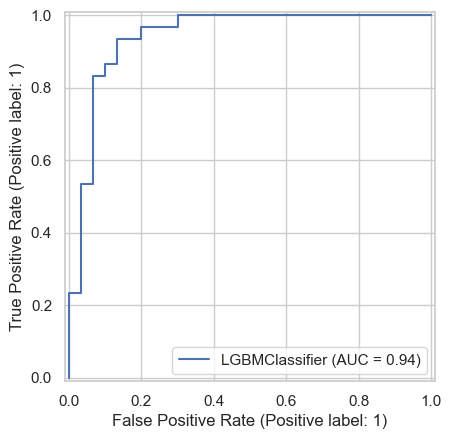

In [206]:
RocCurveDisplay.from_estimator(model_lgbm, X_test_scaled, y_test)

##### Salvando o modelo

In [208]:
pickle.dump(model_lg, open(os.path.join(BASEDIR, "artifacts", "model_lg.pkl"), "wb"))